In [1]:
import numpy as np
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pickle
from copy import deepcopy as copy
# from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# path = '/content/drive/My Drive/WorkSpace/ML/SurrogateModel/'
path = os.getcwd()

# Preprocess Data

In [4]:
ap1_x,ap1_y = 4e-3, 5.5e-3
ang = np.arange(0.0,2*np.pi,2*np.pi/1024)
c = np.cos(ang)
s = np.sin(ang)

In [5]:
nx = 50
testP = 0.0
sig = 0.015
k=0
pTest = []
for x in np.linspace(-ap1_x*0.95,ap1_x*0.95,nx):
    for y in np.linspace(-ap1_y*0.95,ap1_y*0.95,nx):
        circ = np.sqrt((x/ap1_x)**2 + (y/ap1_y)**2)
        arcR = np.sqrt(((x-1.3*ap1_x)/ap1_x)**2 + (y/(1.1*ap1_y))**2)
        arcL = np.sqrt(((x+1.3*ap1_x)/ap1_x)**2 + (y/(1.1*ap1_y))**2)
        if circ < 0.95 and y>0:
            if x> 0 and 0.6 < arcR and (circ > 0.75 or  arcR < 0.8):
                pTest.append([x,y])
                k=k+1
            elif x<0 and 0.6 < arcL and (circ > 0.75 or  arcL < 0.8):
                pTest.append([x,y])
                k=k+1
pTest0 = np.array(pTest)
pTest1 = copy(pTest0)
pTest2 = copy(pTest0)
pTest = np.concatenate((pTest0,pTest1,pTest2))
npt = len(pTest0)
npt

352

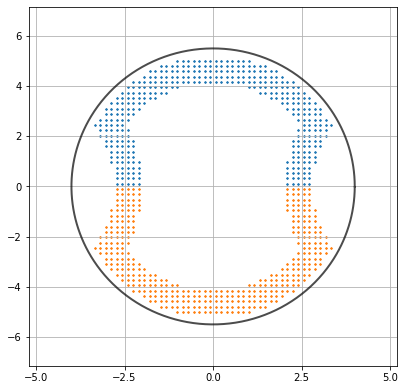

In [6]:
fig = plt.figure(figsize=[3.3*2,3.3*2])
plt.scatter(pTest[:,0]*1e3, pTest[:,1]*1e3,s=1)
plt.scatter(pTest[:,0]*1e3,-pTest[:,1]*1e3,s=1)
plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
plt.xticks([-5,-2.5,0,2.5,5])
plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)
plt.grid()

In [7]:
data = pickle.load(open(path+'/data_4_surrogate.pickle','rb'))
data.keys()

dict_keys(['regular', 'chaotic'])

In [8]:
data['regular'].keys()

dict_keys(['inputs', 'outputs'])

In [9]:
len(data['regular']['inputs']),len(data['chaotic']['inputs'])

(2190, 4810)

In [10]:
dataRatio_regular_chaotic = 1.0*len(data['regular']['inputs'])/len(data['chaotic']['inputs'])

In [11]:
i=0
output = data['regular']['outputs'][i]
indx = output[:3]
diff = output[3:]
diffSum0 = np.array([np.sum(diff[i]) for i in range(3)]) 
diffSum1 = diffSum0+ np.array([np.max(diff[i])*(npt-len(indx[i])) for i in range(3)])

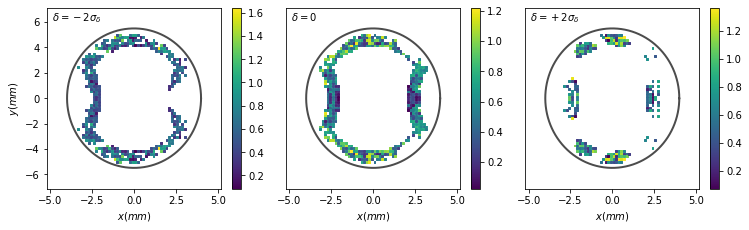

In [12]:
txt = [r'$\delta=-2\sigma_{\delta}$',r'$\delta=0$',r'$\delta=+2\sigma_{\delta}$']
fig = plt.figure(figsize=[4+3.3+3.3,3.3])
for i in range(3):
    plt.subplot(1,3,i+1)
    d = diff[i]
    x = pTest[indx[i],0]
    y = pTest[indx[i],1]
    f1=plt.scatter(x*1e3,y*1e3,c=d,s=3.5,marker='s')
    plt.scatter(x*1e3,-y*1e3,c=d,s=3.5,marker='s')
    plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
    plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
    plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)
    plt.xlabel('$x (mm)$')
    if i==0:
        plt.ylabel('$y (mm)$')
    else:
        plt.yticks([])
    plt.text(-4.9,6.1,txt[i])
    plt.colorbar(f1)
plt.tight_layout()

In [13]:
diffSum0, diffSum1

(array([129.74292158, 139.07139999,  76.43660729]),
 array([355.05298922, 269.82700435, 400.06296158]))

In [14]:
regular_data = np.zeros([len(data['regular']['outputs']),13])


for i in range(len(data['regular']['outputs'])):
  inputs = data['regular']['inputs'][i].astype(float)
  outputs = data['regular']['outputs'][i]
  indx = outputs[:3]
  diff = outputs[3:]
  diffSum0 = np.array([np.sum(diff[i]) for i in range(3)]) 
  diffSum1 = diffSum0+ np.array([np.max(diff[i])*(npt-len(indx[i])) for i in range(3)])
  obj = 0.15*diffSum1[0] +0.7*diffSum1[1] +0.15*diffSum1[2]
  regular_data[i,:12] = inputs
  regular_data[i, -1] = obj

In [15]:
argmax = np.argmax(regular_data[:, -1])
argmin = np.argmin(regular_data[:, -1])

max_ragular_obj = regular_data[argmax, -1]
min_ragular_obj = regular_data[argmin, -1]

min_ragular_obj_input = regular_data[argmax,:12]

In [16]:
min_ragular_obj, max_ragular_obj

(0.23279389823473132, 436.95685313867324)

In [17]:
min_ragular_obj_input

array([-0.44882499,  0.23938186, -1.93820955, -0.26221016,  0.62410466,
       -3.42845608, -1.08748973, -1.59559679, -1.34231546,  0.50175036,
        0.15319918,  1.98356596])

In [18]:
output = data['regular']['outputs'][argmin]
indx = output[:3]
diff = output[3:]
diffSum0 = np.array([np.sum(diff[i]) for i in range(3)]) 
diffSum1 = diffSum0+ np.array([np.max(diff[i])*(npt-len(indx[i])) for i in range(3)])

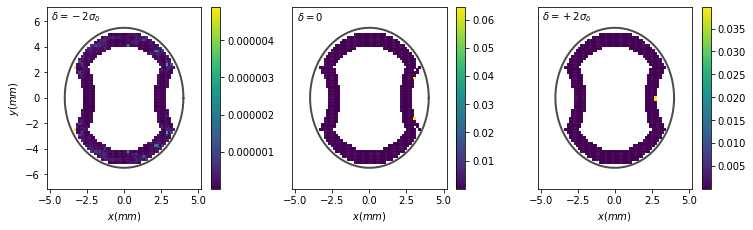

In [19]:
txt = [r'$\delta=-2\sigma_{\delta}$',r'$\delta=0$',r'$\delta=+2\sigma_{\delta}$']
fig = plt.figure(figsize=[4+3.3+3.3,3.3])
for i in range(3):
    plt.subplot(1,3,i+1)
    d = diff[i]
    x = pTest[indx[i],0]
    y = pTest[indx[i],1]
    f1=plt.scatter(x*1e3,y*1e3,c=d,s=3.5,marker='s')
    plt.scatter(x*1e3,-y*1e3,c=d,s=3.5,marker='s')
    plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
    plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
    plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)
    plt.xlabel('$x (mm)$')
    if i==0:
        plt.ylabel('$y (mm)$')
    else:
        plt.yticks([])
    plt.text(-4.9,6.1,txt[i])
    plt.colorbar(f1)
plt.tight_layout()

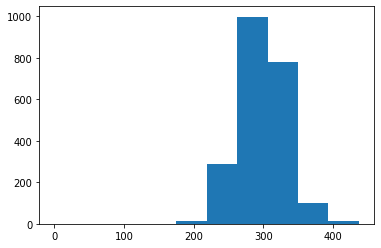

In [20]:
loader = torch.utils.data.DataLoader(regular_data, batch_size=len(regular_data), shuffle=False)
for tmp in loader:
  plt.hist(tmp[:,-1])

In [21]:
chaotic_data = np.zeros([len(data['chaotic']['outputs']),13])

for i in range(len(data['chaotic']['outputs'])):
  inputs = data['chaotic']['inputs'][i].astype(float)
  outputs = data['chaotic']['outputs'][i][0]
  obj = max_ragular_obj + (100-outputs)/100*np.abs(max_ragular_obj)
  chaotic_data[i][:12] = inputs
  chaotic_data[i][ -1] = obj

torch.Size([4810])


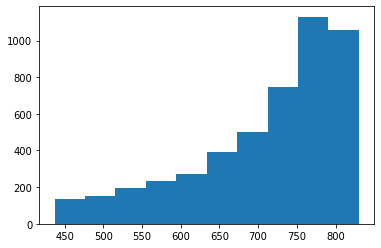

In [22]:
loader = torch.utils.data.DataLoader(chaotic_data, batch_size=len(chaotic_data), shuffle=False)
for tmp in loader:
  print(tmp[:,-1].shape)
  plt.hist(tmp[:,-1])

In [23]:
data = np.concatenate((regular_data,chaotic_data))
data = data.astype(np.float32)
np.random.shuffle(data)
data.shape

(7000, 13)

In [24]:
mean = data.mean(axis=0)
std = data.std(axis=0)
lower_bounds = data.min(axis=0)
upper_bounds = data.max(axis=0)

lower_bounds, upper_bounds, mean, std

(array([-6.2797165, -7.437865 , -8.789994 , -8.577939 , -7.430486 ,
        -7.154883 , -7.57173  , -7.064572 , -7.473061 , -7.16409  ,
        -6.9996614, -7.196005 ,  0.2327939], dtype=float32),
 array([  7.3388243,   7.3545423,   7.560626 ,   7.0834208,   8.647709 ,
          8.089222 ,   7.2863803,   7.692415 ,   7.3403726,   7.16727  ,
          7.3005333,   7.138283 , 830.218    ], dtype=float32),
 array([ 1.0714499e-02,  2.3793587e-02,  2.6073061e-02,  1.7092612e-02,
         6.1364632e-02, -2.9230678e-02,  4.1981053e-02,  1.1282748e-02,
         2.7793244e-02, -2.8429436e-02,  1.0627134e-02, -1.3047621e-02,
         5.8742175e+02], dtype=float32),
 array([  1.9766399,   2.0125384,   2.0005622,   1.9953978,   1.9828788,
          2.0183194,   2.0068295,   2.0400712,   2.0016947,   1.9919165,
          1.9887491,   2.0299063, 215.43661  ], dtype=float32))

In [25]:
data[:,:12] = data[:,:12]/2.0
data[:,-1] = (data[:,-1]-mean[-1])/std[-1]

In [26]:
data.mean(axis=0), data.std(axis=0), data.min(axis=0), data.max(axis=0)

(array([ 5.3572496e-03,  1.1896794e-02,  1.3036530e-02,  8.5463058e-03,
         3.0682316e-02, -1.4615339e-02,  2.0990526e-02,  5.6413738e-03,
         1.3896622e-02, -1.4214718e-02,  5.3135669e-03, -6.5238103e-03,
        -3.9235865e-06], dtype=float32),
 array([0.98831993, 1.0062692 , 1.0002811 , 0.9976989 , 0.9914394 ,
        1.0091597 , 1.0034148 , 1.0200356 , 1.0008473 , 0.99595827,
        0.9943746 , 1.0149531 , 0.9999938 ], dtype=float32),
 array([-3.1398582, -3.7189324, -4.394997 , -4.2889695, -3.715243 ,
        -3.5774415, -3.785865 , -3.532286 , -3.7365305, -3.582045 ,
        -3.4998307, -3.5980024, -2.7255764], dtype=float32),
 array([3.6694121, 3.6772711, 3.780313 , 3.5417104, 4.3238544, 4.044611 ,
        3.6431901, 3.8462076, 3.6701863, 3.583635 , 3.6502666, 3.5691414,
        1.1269963], dtype=float32))

In [27]:
train_data_loader = torch.utils.data.DataLoader(data[:int(0.6*len(data)),:], batch_size=500, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(data[int(0.6*len(data)):int(0.8*len(data)),:], batch_size=500, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(data[int(0.8*len(data)):,:], batch_size=500, shuffle=True)

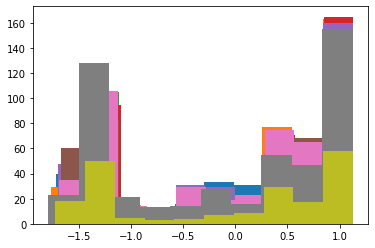

In [28]:
for tmp in train_data_loader:
  plt.hist(tmp[:,-1])

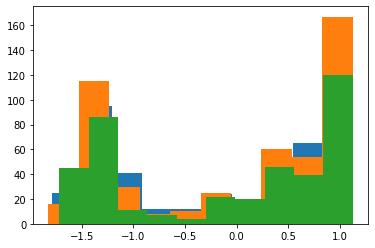

In [29]:
for tmp in test_data_loader:
  plt.hist(tmp[:,-1])

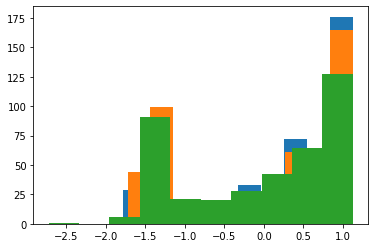

In [30]:
for tmp in val_data_loader:
  plt.hist(tmp[:,-1])

# Build Model

In [78]:
class FCNN(torch.nn.Module):
  def __init__(self, **kwargs):
    super(FCNN,self).__init__()

    self.nodes = kwargs["nodes"]
    self.activation = kwargs["activation"]
    self.dropout_p = kwargs["dropout_p"]

    self.seq = [torch.nn.Linear(12,self.nodes[0]),torch.nn.Dropout(self.dropout_p),self.activation]
    for i in range(len(self.nodes)-1):
      self.seq = self.seq + [torch.nn.Linear(self.nodes[i],self.nodes[i+1]),torch.nn.Dropout(self.dropout_p), self.activation]
    if len(self.nodes)==1:
        self.seq = self.seq + [torch.nn.Linear(self.nodes[0],1)]
    else:
        self.seq = self.seq + [torch.nn.Linear(self.nodes[i+1],1)]

    self.nn = torch.nn.Sequential(*self.seq)

  def forward(self, x):
      return self.nn(x)

# Train

In [32]:
def train(epochs,nodes,activation,dropout_p,lr):
  model = FCNN(nodes=nodes,activation=activation,dropout_p=dropout_p).to(device)
  # print(model.seq)
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  criterion = torch.nn.MSELoss()
  hist = {'train_loss':np.zeros(epochs),
          'test_loss' :np.zeros(epochs)}
  for epoch in range(epochs):
      model.train()
      train_loss = 0
      for data in train_data_loader:
          inputs = data[:,:12]
          outputs = data[:,-1].reshape(len(data[:,-1]),-1)
          optimizer.zero_grad()
          inputs = inputs.to(device)
          # print('inputs.shape',inputs.shape)
          model_outputs = model(inputs)
          # print('model_outputs.shape',model_outputs.shape)
          # print('outputs.shape',outputs.shape)
          loss = criterion(outputs.to(device), model_outputs)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

      train_loss /= len(train_data_loader)


      model.eval()
      test_loss = 0
      with torch.no_grad():
          for data in test_data_loader:
              inputs = data[:,:12]
              outputs = data[:,-1].reshape(len(data[:,-1]),-1)
              # inputs = inputs.float().to(device)
              inputs = inputs.to(device)
              model_outputs = model(inputs)
              loss = criterion(outputs.to(device), model_outputs)
              test_loss += loss.item()

      test_loss /= len(test_data_loader)

      hist['train_loss'][epoch] = train_loss
      hist['test_loss'][epoch] = test_loss


      if epoch == int(0.3*epochs):
          best_loss = test_loss
      if epoch > int(0.3*epochs):
          if test_loss < best_loss:
              best_loss = test_loss
              checkpoint = {'epoch':epoch+1, 'state_dict':model.state_dict(), 'optimizer':optimizer.state_dict()}
              torch.save(checkpoint, path+'/[0th]best.checkpoint')
      
      # display the epoch training loss
      print("epoch : {}/{}, train loss = {:.6f}, test loss = {:.6f}".format(epoch + 1, epochs, hist['train_loss'][epoch], hist['test_loss'][epoch]))

  checkpoint = torch.load(path+'/[0th]best.checkpoint')
  model.load_state_dict(checkpoint['state_dict'])
  val_err = 0
  with torch.no_grad():
      for data in val_data_loader:
          inputs = data[:,:12]
          outputs = data[:,-1].reshape(len(data[:,-1]),-1)
          inputs = inputs.float().to(device)
          model_outpus = model(inputs)
          val_err += F.mse_loss(model_outpus, outputs.to(device)).item()
  val_err /= len(val_data_loader)

  return model,hist,val_err

### LeakyReLU

In [33]:
model,hist,val_err = train(100,[16,32,32,16],torch.nn.LeakyReLU(inplace=True),0.2,1e-3)

epoch : 1/100, train loss = 0.989798, test loss = 1.037145
epoch : 2/100, train loss = 0.988569, test loss = 1.033263
epoch : 3/100, train loss = 0.987291, test loss = 1.025232
epoch : 4/100, train loss = 0.967319, test loss = 1.012686
epoch : 5/100, train loss = 0.954160, test loss = 0.985207
epoch : 6/100, train loss = 0.934396, test loss = 0.952962
epoch : 7/100, train loss = 0.913606, test loss = 0.910628
epoch : 8/100, train loss = 0.865857, test loss = 0.846154
epoch : 9/100, train loss = 0.825878, test loss = 0.771314
epoch : 10/100, train loss = 0.787322, test loss = 0.695325
epoch : 11/100, train loss = 0.722993, test loss = 0.640687
epoch : 12/100, train loss = 0.693646, test loss = 0.577608
epoch : 13/100, train loss = 0.656788, test loss = 0.545399
epoch : 14/100, train loss = 0.644219, test loss = 0.502432
epoch : 15/100, train loss = 0.611348, test loss = 0.479930
epoch : 16/100, train loss = 0.598704, test loss = 0.453968
epoch : 17/100, train loss = 0.570928, test loss 

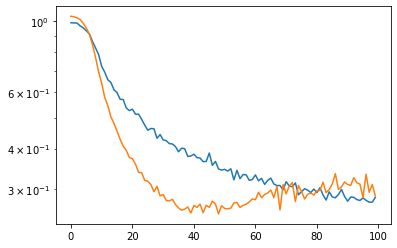

In [34]:
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])

In [35]:
val_err

0.2574421515067418

### Tanh

In [55]:
model,hist,val_err = train(400,[16,32,32,16],torch.nn.Tanh(),0.2,1e-3)

epoch : 1/400, train loss = 0.998093, test loss = 1.040048
epoch : 2/400, train loss = 0.992829, test loss = 1.040155
epoch : 3/400, train loss = 0.989794, test loss = 1.034847
epoch : 4/400, train loss = 0.984829, test loss = 1.027680
epoch : 5/400, train loss = 0.981249, test loss = 1.027017
epoch : 6/400, train loss = 0.972497, test loss = 1.022218
epoch : 7/400, train loss = 0.975411, test loss = 1.019076
epoch : 8/400, train loss = 0.972232, test loss = 1.014990
epoch : 9/400, train loss = 0.974853, test loss = 1.007192
epoch : 10/400, train loss = 0.967719, test loss = 1.002416
epoch : 11/400, train loss = 0.960099, test loss = 1.000044
epoch : 12/400, train loss = 0.957473, test loss = 0.998651
epoch : 13/400, train loss = 0.959336, test loss = 0.990315
epoch : 14/400, train loss = 0.951875, test loss = 0.982251
epoch : 15/400, train loss = 0.932169, test loss = 0.970430
epoch : 16/400, train loss = 0.930653, test loss = 0.957041
epoch : 17/400, train loss = 0.926400, test loss 

epoch : 139/400, train loss = 0.408306, test loss = 0.458465
epoch : 140/400, train loss = 0.415115, test loss = 0.417714
epoch : 141/400, train loss = 0.417601, test loss = 0.481392
epoch : 142/400, train loss = 0.406965, test loss = 0.421445
epoch : 143/400, train loss = 0.416960, test loss = 0.471394
epoch : 144/400, train loss = 0.411935, test loss = 0.436080
epoch : 145/400, train loss = 0.411689, test loss = 0.470253
epoch : 146/400, train loss = 0.416205, test loss = 0.463867
epoch : 147/400, train loss = 0.426309, test loss = 0.457823
epoch : 148/400, train loss = 0.410255, test loss = 0.436427
epoch : 149/400, train loss = 0.410114, test loss = 0.430567
epoch : 150/400, train loss = 0.411068, test loss = 0.454887
epoch : 151/400, train loss = 0.414885, test loss = 0.435741
epoch : 152/400, train loss = 0.410004, test loss = 0.447914
epoch : 153/400, train loss = 0.401173, test loss = 0.440351
epoch : 154/400, train loss = 0.397298, test loss = 0.452131
epoch : 155/400, train l

epoch : 275/400, train loss = 0.376135, test loss = 0.406697
epoch : 276/400, train loss = 0.368612, test loss = 0.443382
epoch : 277/400, train loss = 0.359857, test loss = 0.434007
epoch : 278/400, train loss = 0.366757, test loss = 0.413875
epoch : 279/400, train loss = 0.366975, test loss = 0.408465
epoch : 280/400, train loss = 0.361168, test loss = 0.427858
epoch : 281/400, train loss = 0.364632, test loss = 0.407094
epoch : 282/400, train loss = 0.368092, test loss = 0.400607
epoch : 283/400, train loss = 0.366641, test loss = 0.433754
epoch : 284/400, train loss = 0.370751, test loss = 0.434567
epoch : 285/400, train loss = 0.350190, test loss = 0.411396
epoch : 286/400, train loss = 0.346985, test loss = 0.416738
epoch : 287/400, train loss = 0.365351, test loss = 0.408581
epoch : 288/400, train loss = 0.347368, test loss = 0.443234
epoch : 289/400, train loss = 0.362293, test loss = 0.366780
epoch : 290/400, train loss = 0.359762, test loss = 0.485468
epoch : 291/400, train l

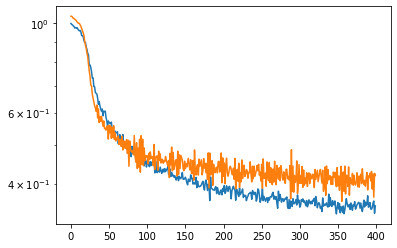

In [56]:
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])

In [57]:
val_err

0.3569280703862508

### Wider and Shallower

In [61]:
model,hist,val_err = train(1000,[128,128],torch.nn.LeakyReLU(inplace=True),0.2,1e-3)

epoch : 1/1000, train loss = 0.955313, test loss = 0.972220
epoch : 2/1000, train loss = 0.897071, test loss = 0.905163
epoch : 3/1000, train loss = 0.834157, test loss = 0.829610
epoch : 4/1000, train loss = 0.760290, test loss = 0.727559
epoch : 5/1000, train loss = 0.667261, test loss = 0.617691
epoch : 6/1000, train loss = 0.583089, test loss = 0.519748
epoch : 7/1000, train loss = 0.534585, test loss = 0.453050
epoch : 8/1000, train loss = 0.489056, test loss = 0.404081
epoch : 9/1000, train loss = 0.465528, test loss = 0.384042
epoch : 10/1000, train loss = 0.451926, test loss = 0.368298
epoch : 11/1000, train loss = 0.429401, test loss = 0.354049
epoch : 12/1000, train loss = 0.421769, test loss = 0.339377
epoch : 13/1000, train loss = 0.402850, test loss = 0.327170
epoch : 14/1000, train loss = 0.385164, test loss = 0.309892
epoch : 15/1000, train loss = 0.368230, test loss = 0.293734
epoch : 16/1000, train loss = 0.352871, test loss = 0.280298
epoch : 17/1000, train loss = 0.3

epoch : 136/1000, train loss = 0.131833, test loss = 0.121432
epoch : 137/1000, train loss = 0.128683, test loss = 0.122487
epoch : 138/1000, train loss = 0.123661, test loss = 0.122976
epoch : 139/1000, train loss = 0.127963, test loss = 0.119826
epoch : 140/1000, train loss = 0.124452, test loss = 0.121706
epoch : 141/1000, train loss = 0.125379, test loss = 0.117945
epoch : 142/1000, train loss = 0.127531, test loss = 0.118633
epoch : 143/1000, train loss = 0.122471, test loss = 0.120904
epoch : 144/1000, train loss = 0.120518, test loss = 0.119257
epoch : 145/1000, train loss = 0.126151, test loss = 0.117991
epoch : 146/1000, train loss = 0.126383, test loss = 0.118005
epoch : 147/1000, train loss = 0.121188, test loss = 0.119967
epoch : 148/1000, train loss = 0.125036, test loss = 0.120385
epoch : 149/1000, train loss = 0.124458, test loss = 0.119143
epoch : 150/1000, train loss = 0.125716, test loss = 0.118748
epoch : 151/1000, train loss = 0.124533, test loss = 0.122024
epoch : 

epoch : 271/1000, train loss = 0.096755, test loss = 0.107010
epoch : 272/1000, train loss = 0.090534, test loss = 0.104258
epoch : 273/1000, train loss = 0.090098, test loss = 0.104000
epoch : 274/1000, train loss = 0.092450, test loss = 0.106103
epoch : 275/1000, train loss = 0.091096, test loss = 0.104555
epoch : 276/1000, train loss = 0.095222, test loss = 0.104295
epoch : 277/1000, train loss = 0.092540, test loss = 0.105143
epoch : 278/1000, train loss = 0.094402, test loss = 0.103111
epoch : 279/1000, train loss = 0.092754, test loss = 0.105209
epoch : 280/1000, train loss = 0.094487, test loss = 0.105446
epoch : 281/1000, train loss = 0.086905, test loss = 0.101280
epoch : 282/1000, train loss = 0.090046, test loss = 0.105286
epoch : 283/1000, train loss = 0.088753, test loss = 0.105410
epoch : 284/1000, train loss = 0.094386, test loss = 0.104270
epoch : 285/1000, train loss = 0.094121, test loss = 0.103870
epoch : 286/1000, train loss = 0.086772, test loss = 0.103650
epoch : 

epoch : 404/1000, train loss = 0.079393, test loss = 0.102270
epoch : 405/1000, train loss = 0.077639, test loss = 0.101030
epoch : 406/1000, train loss = 0.080279, test loss = 0.103295
epoch : 407/1000, train loss = 0.077425, test loss = 0.101361
epoch : 408/1000, train loss = 0.076662, test loss = 0.101799
epoch : 409/1000, train loss = 0.077023, test loss = 0.103724
epoch : 410/1000, train loss = 0.077726, test loss = 0.100090
epoch : 411/1000, train loss = 0.076699, test loss = 0.101064
epoch : 412/1000, train loss = 0.079604, test loss = 0.100341
epoch : 413/1000, train loss = 0.073110, test loss = 0.102078
epoch : 414/1000, train loss = 0.076994, test loss = 0.098831
epoch : 415/1000, train loss = 0.076290, test loss = 0.101860
epoch : 416/1000, train loss = 0.077697, test loss = 0.099840
epoch : 417/1000, train loss = 0.078290, test loss = 0.101284
epoch : 418/1000, train loss = 0.074855, test loss = 0.101620
epoch : 419/1000, train loss = 0.075740, test loss = 0.100722
epoch : 

epoch : 538/1000, train loss = 0.068755, test loss = 0.101794
epoch : 539/1000, train loss = 0.068157, test loss = 0.101203
epoch : 540/1000, train loss = 0.070576, test loss = 0.104325
epoch : 541/1000, train loss = 0.070160, test loss = 0.105662
epoch : 542/1000, train loss = 0.066819, test loss = 0.101565
epoch : 543/1000, train loss = 0.068746, test loss = 0.101546
epoch : 544/1000, train loss = 0.066270, test loss = 0.104205
epoch : 545/1000, train loss = 0.069680, test loss = 0.102399
epoch : 546/1000, train loss = 0.069655, test loss = 0.101279
epoch : 547/1000, train loss = 0.068604, test loss = 0.101218
epoch : 548/1000, train loss = 0.072022, test loss = 0.100508
epoch : 549/1000, train loss = 0.067065, test loss = 0.104039
epoch : 550/1000, train loss = 0.069742, test loss = 0.100069
epoch : 551/1000, train loss = 0.066748, test loss = 0.099798
epoch : 552/1000, train loss = 0.067419, test loss = 0.102838
epoch : 553/1000, train loss = 0.067642, test loss = 0.101763
epoch : 

epoch : 672/1000, train loss = 0.063871, test loss = 0.099850
epoch : 673/1000, train loss = 0.061334, test loss = 0.098974
epoch : 674/1000, train loss = 0.066426, test loss = 0.100320
epoch : 675/1000, train loss = 0.060987, test loss = 0.099555
epoch : 676/1000, train loss = 0.060767, test loss = 0.099622
epoch : 677/1000, train loss = 0.061608, test loss = 0.101456
epoch : 678/1000, train loss = 0.063103, test loss = 0.099608
epoch : 679/1000, train loss = 0.061553, test loss = 0.102766
epoch : 680/1000, train loss = 0.062429, test loss = 0.098472
epoch : 681/1000, train loss = 0.059698, test loss = 0.100553
epoch : 682/1000, train loss = 0.064732, test loss = 0.100264
epoch : 683/1000, train loss = 0.064717, test loss = 0.098395
epoch : 684/1000, train loss = 0.065430, test loss = 0.099739
epoch : 685/1000, train loss = 0.066019, test loss = 0.099450
epoch : 686/1000, train loss = 0.061614, test loss = 0.099389
epoch : 687/1000, train loss = 0.064522, test loss = 0.098130
epoch : 

epoch : 806/1000, train loss = 0.059178, test loss = 0.102799
epoch : 807/1000, train loss = 0.060653, test loss = 0.099314
epoch : 808/1000, train loss = 0.059546, test loss = 0.098616
epoch : 809/1000, train loss = 0.055999, test loss = 0.099119
epoch : 810/1000, train loss = 0.057551, test loss = 0.101599
epoch : 811/1000, train loss = 0.057302, test loss = 0.097726
epoch : 812/1000, train loss = 0.058343, test loss = 0.099272
epoch : 813/1000, train loss = 0.058035, test loss = 0.099543
epoch : 814/1000, train loss = 0.059314, test loss = 0.099922
epoch : 815/1000, train loss = 0.058677, test loss = 0.101580
epoch : 816/1000, train loss = 0.058476, test loss = 0.099639
epoch : 817/1000, train loss = 0.055434, test loss = 0.102476
epoch : 818/1000, train loss = 0.058274, test loss = 0.099266
epoch : 819/1000, train loss = 0.057883, test loss = 0.099747
epoch : 820/1000, train loss = 0.057821, test loss = 0.099523
epoch : 821/1000, train loss = 0.060369, test loss = 0.100566
epoch : 

epoch : 940/1000, train loss = 0.057261, test loss = 0.100450
epoch : 941/1000, train loss = 0.055460, test loss = 0.097494
epoch : 942/1000, train loss = 0.055832, test loss = 0.097563
epoch : 943/1000, train loss = 0.054758, test loss = 0.096987
epoch : 944/1000, train loss = 0.056745, test loss = 0.095127
epoch : 945/1000, train loss = 0.052629, test loss = 0.095089
epoch : 946/1000, train loss = 0.052712, test loss = 0.096753
epoch : 947/1000, train loss = 0.056568, test loss = 0.096189
epoch : 948/1000, train loss = 0.056436, test loss = 0.095272
epoch : 949/1000, train loss = 0.055279, test loss = 0.096856
epoch : 950/1000, train loss = 0.054910, test loss = 0.097242
epoch : 951/1000, train loss = 0.056000, test loss = 0.098151
epoch : 952/1000, train loss = 0.055090, test loss = 0.097887
epoch : 953/1000, train loss = 0.055125, test loss = 0.097925
epoch : 954/1000, train loss = 0.055329, test loss = 0.098145
epoch : 955/1000, train loss = 0.054354, test loss = 0.099613
epoch : 

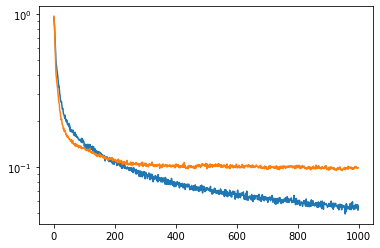

In [62]:
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])

In [63]:
val_err

0.08795709659655888

### Narrower and Deeper

In [49]:
model,hist,val_err = train(1000,[16,16,8,4,4,8,8],torch.nn.LeakyReLU(inplace=True),0.2,1e-3)

epoch : 1/1000, train loss = 0.994360, test loss = 1.044396
epoch : 2/1000, train loss = 0.993652, test loss = 1.046788
epoch : 3/1000, train loss = 0.993337, test loss = 1.044232
epoch : 4/1000, train loss = 0.996343, test loss = 1.046035
epoch : 5/1000, train loss = 0.987019, test loss = 1.042902
epoch : 6/1000, train loss = 0.989042, test loss = 1.039762
epoch : 7/1000, train loss = 0.995453, test loss = 1.043130
epoch : 8/1000, train loss = 0.995400, test loss = 1.044487
epoch : 9/1000, train loss = 0.986184, test loss = 1.045907
epoch : 10/1000, train loss = 0.991816, test loss = 1.043403
epoch : 11/1000, train loss = 0.991192, test loss = 1.041518
epoch : 12/1000, train loss = 0.989581, test loss = 1.042975
epoch : 13/1000, train loss = 0.985840, test loss = 1.040838
epoch : 14/1000, train loss = 0.987273, test loss = 1.040139
epoch : 15/1000, train loss = 0.987106, test loss = 1.042133
epoch : 16/1000, train loss = 0.984210, test loss = 1.043344
epoch : 17/1000, train loss = 0.9

epoch : 135/1000, train loss = 0.396088, test loss = 0.275072
epoch : 136/1000, train loss = 0.400492, test loss = 0.273809
epoch : 137/1000, train loss = 0.393478, test loss = 0.275017
epoch : 138/1000, train loss = 0.426048, test loss = 0.284949
epoch : 139/1000, train loss = 0.420528, test loss = 0.282557
epoch : 140/1000, train loss = 0.405464, test loss = 0.274293
epoch : 141/1000, train loss = 0.395485, test loss = 0.272791
epoch : 142/1000, train loss = 0.399476, test loss = 0.277565
epoch : 143/1000, train loss = 0.393323, test loss = 0.285738
epoch : 144/1000, train loss = 0.396169, test loss = 0.266375
epoch : 145/1000, train loss = 0.399652, test loss = 0.272189
epoch : 146/1000, train loss = 0.390879, test loss = 0.279564
epoch : 147/1000, train loss = 0.401114, test loss = 0.284082
epoch : 148/1000, train loss = 0.384723, test loss = 0.280983
epoch : 149/1000, train loss = 0.378412, test loss = 0.267094
epoch : 150/1000, train loss = 0.389826, test loss = 0.286262
epoch : 

epoch : 269/1000, train loss = 0.336852, test loss = 0.280405
epoch : 270/1000, train loss = 0.334654, test loss = 0.262053
epoch : 271/1000, train loss = 0.346126, test loss = 0.279282
epoch : 272/1000, train loss = 0.344796, test loss = 0.291699
epoch : 273/1000, train loss = 0.345989, test loss = 0.283708
epoch : 274/1000, train loss = 0.340726, test loss = 0.283610
epoch : 275/1000, train loss = 0.341308, test loss = 0.269930
epoch : 276/1000, train loss = 0.332404, test loss = 0.277112
epoch : 277/1000, train loss = 0.352087, test loss = 0.277718
epoch : 278/1000, train loss = 0.343714, test loss = 0.276512
epoch : 279/1000, train loss = 0.339513, test loss = 0.268104
epoch : 280/1000, train loss = 0.327573, test loss = 0.286031
epoch : 281/1000, train loss = 0.331900, test loss = 0.266047
epoch : 282/1000, train loss = 0.336532, test loss = 0.273642
epoch : 283/1000, train loss = 0.338659, test loss = 0.284425
epoch : 284/1000, train loss = 0.323921, test loss = 0.273779
epoch : 

epoch : 402/1000, train loss = 0.325786, test loss = 0.270005
epoch : 403/1000, train loss = 0.321609, test loss = 0.265904
epoch : 404/1000, train loss = 0.311016, test loss = 0.270514
epoch : 405/1000, train loss = 0.303676, test loss = 0.272038
epoch : 406/1000, train loss = 0.309619, test loss = 0.276718
epoch : 407/1000, train loss = 0.309805, test loss = 0.271523
epoch : 408/1000, train loss = 0.295623, test loss = 0.263006
epoch : 409/1000, train loss = 0.304551, test loss = 0.265683
epoch : 410/1000, train loss = 0.313299, test loss = 0.272630
epoch : 411/1000, train loss = 0.305833, test loss = 0.265740
epoch : 412/1000, train loss = 0.303438, test loss = 0.270610
epoch : 413/1000, train loss = 0.312813, test loss = 0.264445
epoch : 414/1000, train loss = 0.312226, test loss = 0.254119
epoch : 415/1000, train loss = 0.319201, test loss = 0.258022
epoch : 416/1000, train loss = 0.314935, test loss = 0.270102
epoch : 417/1000, train loss = 0.333902, test loss = 0.270945
epoch : 

epoch : 536/1000, train loss = 0.297379, test loss = 0.269689
epoch : 537/1000, train loss = 0.297904, test loss = 0.265403
epoch : 538/1000, train loss = 0.302391, test loss = 0.270082
epoch : 539/1000, train loss = 0.307769, test loss = 0.269888
epoch : 540/1000, train loss = 0.307803, test loss = 0.273302
epoch : 541/1000, train loss = 0.292874, test loss = 0.268075
epoch : 542/1000, train loss = 0.307971, test loss = 0.274816
epoch : 543/1000, train loss = 0.307501, test loss = 0.275135
epoch : 544/1000, train loss = 0.301658, test loss = 0.274646
epoch : 545/1000, train loss = 0.294580, test loss = 0.279469
epoch : 546/1000, train loss = 0.288426, test loss = 0.257297
epoch : 547/1000, train loss = 0.290685, test loss = 0.269494
epoch : 548/1000, train loss = 0.303628, test loss = 0.260956
epoch : 549/1000, train loss = 0.298559, test loss = 0.255842
epoch : 550/1000, train loss = 0.280297, test loss = 0.248412
epoch : 551/1000, train loss = 0.281871, test loss = 0.260511
epoch : 

epoch : 670/1000, train loss = 0.282142, test loss = 0.264253
epoch : 671/1000, train loss = 0.273968, test loss = 0.258009
epoch : 672/1000, train loss = 0.278371, test loss = 0.267736
epoch : 673/1000, train loss = 0.305739, test loss = 0.261977
epoch : 674/1000, train loss = 0.278213, test loss = 0.255970
epoch : 675/1000, train loss = 0.295539, test loss = 0.264569
epoch : 676/1000, train loss = 0.291970, test loss = 0.269038
epoch : 677/1000, train loss = 0.292787, test loss = 0.254302
epoch : 678/1000, train loss = 0.281776, test loss = 0.273291
epoch : 679/1000, train loss = 0.312500, test loss = 0.271381
epoch : 680/1000, train loss = 0.293985, test loss = 0.263085
epoch : 681/1000, train loss = 0.286644, test loss = 0.265914
epoch : 682/1000, train loss = 0.279842, test loss = 0.263363
epoch : 683/1000, train loss = 0.282918, test loss = 0.260278
epoch : 684/1000, train loss = 0.278806, test loss = 0.261870
epoch : 685/1000, train loss = 0.290056, test loss = 0.260788
epoch : 

epoch : 804/1000, train loss = 0.290161, test loss = 0.261995
epoch : 805/1000, train loss = 0.297365, test loss = 0.260765
epoch : 806/1000, train loss = 0.277703, test loss = 0.262997
epoch : 807/1000, train loss = 0.285270, test loss = 0.269188
epoch : 808/1000, train loss = 0.290004, test loss = 0.259568
epoch : 809/1000, train loss = 0.287614, test loss = 0.259725
epoch : 810/1000, train loss = 0.287139, test loss = 0.242888
epoch : 811/1000, train loss = 0.286908, test loss = 0.247360
epoch : 812/1000, train loss = 0.281072, test loss = 0.252184
epoch : 813/1000, train loss = 0.292960, test loss = 0.248362
epoch : 814/1000, train loss = 0.295241, test loss = 0.252971
epoch : 815/1000, train loss = 0.276177, test loss = 0.250775
epoch : 816/1000, train loss = 0.278504, test loss = 0.250899
epoch : 817/1000, train loss = 0.296697, test loss = 0.252056
epoch : 818/1000, train loss = 0.289088, test loss = 0.260817
epoch : 819/1000, train loss = 0.285777, test loss = 0.247815
epoch : 

epoch : 938/1000, train loss = 0.277296, test loss = 0.257293
epoch : 939/1000, train loss = 0.273957, test loss = 0.263562
epoch : 940/1000, train loss = 0.299381, test loss = 0.270973
epoch : 941/1000, train loss = 0.282006, test loss = 0.271747
epoch : 942/1000, train loss = 0.286530, test loss = 0.259438
epoch : 943/1000, train loss = 0.276352, test loss = 0.259386
epoch : 944/1000, train loss = 0.279981, test loss = 0.254880
epoch : 945/1000, train loss = 0.277413, test loss = 0.241021
epoch : 946/1000, train loss = 0.283299, test loss = 0.246980
epoch : 947/1000, train loss = 0.273764, test loss = 0.263987
epoch : 948/1000, train loss = 0.274313, test loss = 0.258161
epoch : 949/1000, train loss = 0.271537, test loss = 0.261382
epoch : 950/1000, train loss = 0.275952, test loss = 0.262596
epoch : 951/1000, train loss = 0.274594, test loss = 0.255276
epoch : 952/1000, train loss = 0.287080, test loss = 0.257421
epoch : 953/1000, train loss = 0.270113, test loss = 0.253376
epoch : 

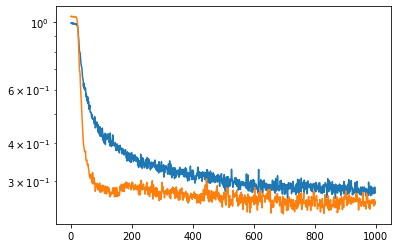

In [50]:
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])

In [51]:
val_err

0.2390399674574534

### More Wider and Shallower

In [73]:
model,hist,val_err = train(1000,[512,16],torch.nn.LeakyReLU(inplace=True),0.2,1e-3)

epoch : 1/1000, train loss = 0.962290, test loss = 0.963970
epoch : 2/1000, train loss = 0.871836, test loss = 0.861243
epoch : 3/1000, train loss = 0.776365, test loss = 0.732345
epoch : 4/1000, train loss = 0.678609, test loss = 0.609762
epoch : 5/1000, train loss = 0.583082, test loss = 0.497013
epoch : 6/1000, train loss = 0.497590, test loss = 0.409064
epoch : 7/1000, train loss = 0.432460, test loss = 0.353944
epoch : 8/1000, train loss = 0.404491, test loss = 0.314964
epoch : 9/1000, train loss = 0.368055, test loss = 0.281227
epoch : 10/1000, train loss = 0.337336, test loss = 0.254413
epoch : 11/1000, train loss = 0.310984, test loss = 0.239217
epoch : 12/1000, train loss = 0.292409, test loss = 0.223083
epoch : 13/1000, train loss = 0.280711, test loss = 0.202463
epoch : 14/1000, train loss = 0.265749, test loss = 0.191529
epoch : 15/1000, train loss = 0.253194, test loss = 0.185418
epoch : 16/1000, train loss = 0.248454, test loss = 0.178382
epoch : 17/1000, train loss = 0.2

epoch : 135/1000, train loss = 0.136596, test loss = 0.132158
epoch : 136/1000, train loss = 0.131600, test loss = 0.124401
epoch : 137/1000, train loss = 0.133339, test loss = 0.126559
epoch : 138/1000, train loss = 0.131919, test loss = 0.125917
epoch : 139/1000, train loss = 0.131843, test loss = 0.129770
epoch : 140/1000, train loss = 0.132944, test loss = 0.124802
epoch : 141/1000, train loss = 0.131726, test loss = 0.130381
epoch : 142/1000, train loss = 0.128990, test loss = 0.123313
epoch : 143/1000, train loss = 0.132193, test loss = 0.125782
epoch : 144/1000, train loss = 0.130103, test loss = 0.123896
epoch : 145/1000, train loss = 0.133211, test loss = 0.124892
epoch : 146/1000, train loss = 0.129470, test loss = 0.124381
epoch : 147/1000, train loss = 0.131380, test loss = 0.124161
epoch : 148/1000, train loss = 0.132489, test loss = 0.125349
epoch : 149/1000, train loss = 0.129834, test loss = 0.123676
epoch : 150/1000, train loss = 0.133751, test loss = 0.123907
epoch : 

epoch : 268/1000, train loss = 0.110029, test loss = 0.114560
epoch : 269/1000, train loss = 0.108059, test loss = 0.115094
epoch : 270/1000, train loss = 0.113108, test loss = 0.116274
epoch : 271/1000, train loss = 0.111652, test loss = 0.113815
epoch : 272/1000, train loss = 0.113393, test loss = 0.117012
epoch : 273/1000, train loss = 0.111534, test loss = 0.112953
epoch : 274/1000, train loss = 0.109351, test loss = 0.113723
epoch : 275/1000, train loss = 0.115876, test loss = 0.114518
epoch : 276/1000, train loss = 0.111472, test loss = 0.112562
epoch : 277/1000, train loss = 0.115287, test loss = 0.113646
epoch : 278/1000, train loss = 0.111670, test loss = 0.114085
epoch : 279/1000, train loss = 0.113526, test loss = 0.113369
epoch : 280/1000, train loss = 0.111873, test loss = 0.113284
epoch : 281/1000, train loss = 0.108605, test loss = 0.112262
epoch : 282/1000, train loss = 0.116336, test loss = 0.112105
epoch : 283/1000, train loss = 0.109613, test loss = 0.110543
epoch : 

epoch : 402/1000, train loss = 0.104142, test loss = 0.102158
epoch : 403/1000, train loss = 0.100788, test loss = 0.108875
epoch : 404/1000, train loss = 0.099436, test loss = 0.107637
epoch : 405/1000, train loss = 0.101778, test loss = 0.108319
epoch : 406/1000, train loss = 0.101095, test loss = 0.104589
epoch : 407/1000, train loss = 0.102130, test loss = 0.105746
epoch : 408/1000, train loss = 0.101014, test loss = 0.101983
epoch : 409/1000, train loss = 0.103032, test loss = 0.102712
epoch : 410/1000, train loss = 0.103994, test loss = 0.100212
epoch : 411/1000, train loss = 0.102380, test loss = 0.101886
epoch : 412/1000, train loss = 0.098529, test loss = 0.105225
epoch : 413/1000, train loss = 0.096297, test loss = 0.102386
epoch : 414/1000, train loss = 0.101953, test loss = 0.100009
epoch : 415/1000, train loss = 0.097780, test loss = 0.103980
epoch : 416/1000, train loss = 0.095603, test loss = 0.105103
epoch : 417/1000, train loss = 0.100083, test loss = 0.103969
epoch : 

epoch : 536/1000, train loss = 0.091467, test loss = 0.103347
epoch : 537/1000, train loss = 0.094564, test loss = 0.100016
epoch : 538/1000, train loss = 0.093334, test loss = 0.098204
epoch : 539/1000, train loss = 0.094682, test loss = 0.100006
epoch : 540/1000, train loss = 0.094453, test loss = 0.098548
epoch : 541/1000, train loss = 0.098284, test loss = 0.101805
epoch : 542/1000, train loss = 0.090213, test loss = 0.099189
epoch : 543/1000, train loss = 0.095504, test loss = 0.098131
epoch : 544/1000, train loss = 0.093796, test loss = 0.099605
epoch : 545/1000, train loss = 0.093198, test loss = 0.098831
epoch : 546/1000, train loss = 0.093821, test loss = 0.100114
epoch : 547/1000, train loss = 0.097097, test loss = 0.098146
epoch : 548/1000, train loss = 0.093545, test loss = 0.099190
epoch : 549/1000, train loss = 0.093350, test loss = 0.099781
epoch : 550/1000, train loss = 0.091879, test loss = 0.099584
epoch : 551/1000, train loss = 0.089516, test loss = 0.098451
epoch : 

epoch : 670/1000, train loss = 0.091033, test loss = 0.094765
epoch : 671/1000, train loss = 0.087363, test loss = 0.093917
epoch : 672/1000, train loss = 0.089328, test loss = 0.095062
epoch : 673/1000, train loss = 0.085931, test loss = 0.094099
epoch : 674/1000, train loss = 0.091951, test loss = 0.098568
epoch : 675/1000, train loss = 0.085350, test loss = 0.095361
epoch : 676/1000, train loss = 0.090187, test loss = 0.092941
epoch : 677/1000, train loss = 0.088358, test loss = 0.094622
epoch : 678/1000, train loss = 0.089755, test loss = 0.099098
epoch : 679/1000, train loss = 0.088319, test loss = 0.095148
epoch : 680/1000, train loss = 0.087100, test loss = 0.101204
epoch : 681/1000, train loss = 0.090091, test loss = 0.093827
epoch : 682/1000, train loss = 0.085809, test loss = 0.098139
epoch : 683/1000, train loss = 0.087026, test loss = 0.096766
epoch : 684/1000, train loss = 0.088790, test loss = 0.096588
epoch : 685/1000, train loss = 0.090609, test loss = 0.098876
epoch : 

epoch : 804/1000, train loss = 0.082189, test loss = 0.096053
epoch : 805/1000, train loss = 0.087910, test loss = 0.102071
epoch : 806/1000, train loss = 0.085248, test loss = 0.097034
epoch : 807/1000, train loss = 0.085364, test loss = 0.093860
epoch : 808/1000, train loss = 0.085564, test loss = 0.096030
epoch : 809/1000, train loss = 0.086503, test loss = 0.096741
epoch : 810/1000, train loss = 0.084831, test loss = 0.096683
epoch : 811/1000, train loss = 0.082840, test loss = 0.097196
epoch : 812/1000, train loss = 0.084179, test loss = 0.092258
epoch : 813/1000, train loss = 0.084727, test loss = 0.095241
epoch : 814/1000, train loss = 0.085569, test loss = 0.100112
epoch : 815/1000, train loss = 0.083757, test loss = 0.095117
epoch : 816/1000, train loss = 0.083871, test loss = 0.091535
epoch : 817/1000, train loss = 0.083551, test loss = 0.092936
epoch : 818/1000, train loss = 0.082929, test loss = 0.101601
epoch : 819/1000, train loss = 0.084791, test loss = 0.095275
epoch : 

epoch : 938/1000, train loss = 0.085324, test loss = 0.099035
epoch : 939/1000, train loss = 0.083543, test loss = 0.099396
epoch : 940/1000, train loss = 0.081214, test loss = 0.098448
epoch : 941/1000, train loss = 0.082582, test loss = 0.095547
epoch : 942/1000, train loss = 0.079986, test loss = 0.093375
epoch : 943/1000, train loss = 0.080335, test loss = 0.096636
epoch : 944/1000, train loss = 0.080053, test loss = 0.100575
epoch : 945/1000, train loss = 0.082340, test loss = 0.094289
epoch : 946/1000, train loss = 0.081797, test loss = 0.095070
epoch : 947/1000, train loss = 0.081964, test loss = 0.098233
epoch : 948/1000, train loss = 0.082382, test loss = 0.102071
epoch : 949/1000, train loss = 0.082022, test loss = 0.096442
epoch : 950/1000, train loss = 0.080028, test loss = 0.097361
epoch : 951/1000, train loss = 0.079567, test loss = 0.094494
epoch : 952/1000, train loss = 0.083256, test loss = 0.097348
epoch : 953/1000, train loss = 0.082407, test loss = 0.095957
epoch : 

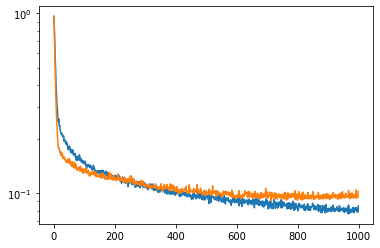

In [74]:
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])

In [75]:
val_err

0.0856088325381279

### More Wider and Shallower

In [108]:
model,hist,val_err = train(2000,[64,32,16,8,4],torch.nn.LeakyReLU(inplace=True),0.25,1e-3)

epoch : 1/2000, train loss = 1.027602, test loss = 1.072789
epoch : 2/2000, train loss = 1.011009, test loss = 1.062593
epoch : 3/2000, train loss = 0.987771, test loss = 1.014168
epoch : 4/2000, train loss = 0.965013, test loss = 0.979903
epoch : 5/2000, train loss = 0.957129, test loss = 0.967044
epoch : 6/2000, train loss = 0.951405, test loss = 0.968386
epoch : 7/2000, train loss = 0.928987, test loss = 0.927580
epoch : 8/2000, train loss = 0.912372, test loss = 0.891360
epoch : 9/2000, train loss = 0.875720, test loss = 0.858840
epoch : 10/2000, train loss = 0.859309, test loss = 0.811956
epoch : 11/2000, train loss = 0.822443, test loss = 0.771633
epoch : 12/2000, train loss = 0.808508, test loss = 0.734217
epoch : 13/2000, train loss = 0.778514, test loss = 0.721844
epoch : 14/2000, train loss = 0.767988, test loss = 0.683249
epoch : 15/2000, train loss = 0.755542, test loss = 0.707067
epoch : 16/2000, train loss = 0.735565, test loss = 0.654191
epoch : 17/2000, train loss = 0.7

epoch : 136/2000, train loss = 0.332528, test loss = 0.196279
epoch : 137/2000, train loss = 0.323680, test loss = 0.195123
epoch : 138/2000, train loss = 0.323240, test loss = 0.194103
epoch : 139/2000, train loss = 0.318985, test loss = 0.187130
epoch : 140/2000, train loss = 0.319400, test loss = 0.180462
epoch : 141/2000, train loss = 0.319169, test loss = 0.187093
epoch : 142/2000, train loss = 0.328634, test loss = 0.192808
epoch : 143/2000, train loss = 0.315586, test loss = 0.179694
epoch : 144/2000, train loss = 0.321703, test loss = 0.186045
epoch : 145/2000, train loss = 0.317702, test loss = 0.183149
epoch : 146/2000, train loss = 0.315449, test loss = 0.185865
epoch : 147/2000, train loss = 0.320152, test loss = 0.181932
epoch : 148/2000, train loss = 0.320798, test loss = 0.187437
epoch : 149/2000, train loss = 0.320525, test loss = 0.189708
epoch : 150/2000, train loss = 0.332338, test loss = 0.188665
epoch : 151/2000, train loss = 0.317478, test loss = 0.190004
epoch : 

epoch : 269/2000, train loss = 0.282692, test loss = 0.177695
epoch : 270/2000, train loss = 0.275397, test loss = 0.187116
epoch : 271/2000, train loss = 0.287948, test loss = 0.180584
epoch : 272/2000, train loss = 0.279320, test loss = 0.180817
epoch : 273/2000, train loss = 0.272238, test loss = 0.173337
epoch : 274/2000, train loss = 0.263823, test loss = 0.177526
epoch : 275/2000, train loss = 0.282696, test loss = 0.181267
epoch : 276/2000, train loss = 0.281829, test loss = 0.175831
epoch : 277/2000, train loss = 0.275503, test loss = 0.175288
epoch : 278/2000, train loss = 0.264596, test loss = 0.179820
epoch : 279/2000, train loss = 0.270153, test loss = 0.174390
epoch : 280/2000, train loss = 0.278629, test loss = 0.196194
epoch : 281/2000, train loss = 0.269654, test loss = 0.183147
epoch : 282/2000, train loss = 0.270025, test loss = 0.184151
epoch : 283/2000, train loss = 0.280927, test loss = 0.188133
epoch : 284/2000, train loss = 0.283001, test loss = 0.183722
epoch : 

epoch : 403/2000, train loss = 0.234651, test loss = 0.161600
epoch : 404/2000, train loss = 0.234911, test loss = 0.163540
epoch : 405/2000, train loss = 0.224953, test loss = 0.166943
epoch : 406/2000, train loss = 0.231352, test loss = 0.171405
epoch : 407/2000, train loss = 0.242368, test loss = 0.168314
epoch : 408/2000, train loss = 0.233374, test loss = 0.159213
epoch : 409/2000, train loss = 0.237152, test loss = 0.161455
epoch : 410/2000, train loss = 0.249191, test loss = 0.170577
epoch : 411/2000, train loss = 0.247229, test loss = 0.169346
epoch : 412/2000, train loss = 0.238713, test loss = 0.156075
epoch : 413/2000, train loss = 0.236696, test loss = 0.158345
epoch : 414/2000, train loss = 0.230473, test loss = 0.171482
epoch : 415/2000, train loss = 0.234029, test loss = 0.168786
epoch : 416/2000, train loss = 0.240521, test loss = 0.181056
epoch : 417/2000, train loss = 0.232251, test loss = 0.152394
epoch : 418/2000, train loss = 0.235341, test loss = 0.166834
epoch : 

epoch : 537/2000, train loss = 0.219844, test loss = 0.145735
epoch : 538/2000, train loss = 0.221259, test loss = 0.167402
epoch : 539/2000, train loss = 0.223581, test loss = 0.154658
epoch : 540/2000, train loss = 0.223994, test loss = 0.155372
epoch : 541/2000, train loss = 0.218579, test loss = 0.161660
epoch : 542/2000, train loss = 0.214444, test loss = 0.155413
epoch : 543/2000, train loss = 0.219693, test loss = 0.162426
epoch : 544/2000, train loss = 0.218501, test loss = 0.161839
epoch : 545/2000, train loss = 0.236454, test loss = 0.157808
epoch : 546/2000, train loss = 0.211536, test loss = 0.159767
epoch : 547/2000, train loss = 0.210824, test loss = 0.143883
epoch : 548/2000, train loss = 0.213118, test loss = 0.160658
epoch : 549/2000, train loss = 0.220915, test loss = 0.166398
epoch : 550/2000, train loss = 0.213581, test loss = 0.168042
epoch : 551/2000, train loss = 0.217454, test loss = 0.145168
epoch : 552/2000, train loss = 0.219555, test loss = 0.154604
epoch : 

epoch : 671/2000, train loss = 0.217570, test loss = 0.152036
epoch : 672/2000, train loss = 0.212900, test loss = 0.163359
epoch : 673/2000, train loss = 0.214166, test loss = 0.144955
epoch : 674/2000, train loss = 0.221721, test loss = 0.152864
epoch : 675/2000, train loss = 0.194724, test loss = 0.149337
epoch : 676/2000, train loss = 0.210503, test loss = 0.158610
epoch : 677/2000, train loss = 0.212220, test loss = 0.145233
epoch : 678/2000, train loss = 0.212685, test loss = 0.149394
epoch : 679/2000, train loss = 0.211536, test loss = 0.160311
epoch : 680/2000, train loss = 0.205063, test loss = 0.152062
epoch : 681/2000, train loss = 0.216234, test loss = 0.150145
epoch : 682/2000, train loss = 0.208321, test loss = 0.142909
epoch : 683/2000, train loss = 0.209536, test loss = 0.143515
epoch : 684/2000, train loss = 0.216425, test loss = 0.145397
epoch : 685/2000, train loss = 0.203304, test loss = 0.160384
epoch : 686/2000, train loss = 0.209227, test loss = 0.170854
epoch : 

epoch : 805/2000, train loss = 0.204945, test loss = 0.157169
epoch : 806/2000, train loss = 0.211439, test loss = 0.160119
epoch : 807/2000, train loss = 0.200962, test loss = 0.163366
epoch : 808/2000, train loss = 0.208838, test loss = 0.143277
epoch : 809/2000, train loss = 0.207504, test loss = 0.152203
epoch : 810/2000, train loss = 0.209978, test loss = 0.149283
epoch : 811/2000, train loss = 0.203077, test loss = 0.162818
epoch : 812/2000, train loss = 0.203412, test loss = 0.151209
epoch : 813/2000, train loss = 0.210231, test loss = 0.173745
epoch : 814/2000, train loss = 0.196910, test loss = 0.159049
epoch : 815/2000, train loss = 0.202982, test loss = 0.157127
epoch : 816/2000, train loss = 0.189608, test loss = 0.143922
epoch : 817/2000, train loss = 0.205095, test loss = 0.170057
epoch : 818/2000, train loss = 0.204530, test loss = 0.148822
epoch : 819/2000, train loss = 0.208822, test loss = 0.144938
epoch : 820/2000, train loss = 0.206533, test loss = 0.151717
epoch : 

epoch : 939/2000, train loss = 0.195720, test loss = 0.147526
epoch : 940/2000, train loss = 0.194189, test loss = 0.167443
epoch : 941/2000, train loss = 0.205639, test loss = 0.158478
epoch : 942/2000, train loss = 0.203245, test loss = 0.157654
epoch : 943/2000, train loss = 0.200961, test loss = 0.156647
epoch : 944/2000, train loss = 0.201403, test loss = 0.157574
epoch : 945/2000, train loss = 0.205603, test loss = 0.158803
epoch : 946/2000, train loss = 0.200872, test loss = 0.158491
epoch : 947/2000, train loss = 0.198914, test loss = 0.167793
epoch : 948/2000, train loss = 0.196915, test loss = 0.161808
epoch : 949/2000, train loss = 0.195356, test loss = 0.156032
epoch : 950/2000, train loss = 0.209687, test loss = 0.154061
epoch : 951/2000, train loss = 0.200232, test loss = 0.150226
epoch : 952/2000, train loss = 0.206378, test loss = 0.158040
epoch : 953/2000, train loss = 0.193748, test loss = 0.156464
epoch : 954/2000, train loss = 0.197448, test loss = 0.158875
epoch : 

epoch : 1071/2000, train loss = 0.195996, test loss = 0.152885
epoch : 1072/2000, train loss = 0.200263, test loss = 0.148362
epoch : 1073/2000, train loss = 0.211958, test loss = 0.156173
epoch : 1074/2000, train loss = 0.201464, test loss = 0.154299
epoch : 1075/2000, train loss = 0.200596, test loss = 0.159979
epoch : 1076/2000, train loss = 0.202581, test loss = 0.171616
epoch : 1077/2000, train loss = 0.196569, test loss = 0.164500
epoch : 1078/2000, train loss = 0.196485, test loss = 0.159437
epoch : 1079/2000, train loss = 0.205792, test loss = 0.156259
epoch : 1080/2000, train loss = 0.207690, test loss = 0.164168
epoch : 1081/2000, train loss = 0.197023, test loss = 0.152108
epoch : 1082/2000, train loss = 0.194956, test loss = 0.166801
epoch : 1083/2000, train loss = 0.200894, test loss = 0.154485
epoch : 1084/2000, train loss = 0.203408, test loss = 0.155147
epoch : 1085/2000, train loss = 0.203418, test loss = 0.165209
epoch : 1086/2000, train loss = 0.199153, test loss = 0

epoch : 1203/2000, train loss = 0.189647, test loss = 0.154052
epoch : 1204/2000, train loss = 0.191965, test loss = 0.163514
epoch : 1205/2000, train loss = 0.200554, test loss = 0.170605
epoch : 1206/2000, train loss = 0.195487, test loss = 0.161161
epoch : 1207/2000, train loss = 0.195384, test loss = 0.154783
epoch : 1208/2000, train loss = 0.198653, test loss = 0.166588
epoch : 1209/2000, train loss = 0.197542, test loss = 0.168502
epoch : 1210/2000, train loss = 0.196744, test loss = 0.157515
epoch : 1211/2000, train loss = 0.183911, test loss = 0.170885
epoch : 1212/2000, train loss = 0.190763, test loss = 0.161558
epoch : 1213/2000, train loss = 0.199823, test loss = 0.152944
epoch : 1214/2000, train loss = 0.200604, test loss = 0.158988
epoch : 1215/2000, train loss = 0.197020, test loss = 0.158721
epoch : 1216/2000, train loss = 0.194339, test loss = 0.159920
epoch : 1217/2000, train loss = 0.205815, test loss = 0.162094
epoch : 1218/2000, train loss = 0.197608, test loss = 0

epoch : 1335/2000, train loss = 0.190583, test loss = 0.150174
epoch : 1336/2000, train loss = 0.195480, test loss = 0.152440
epoch : 1337/2000, train loss = 0.192208, test loss = 0.145612
epoch : 1338/2000, train loss = 0.194064, test loss = 0.163354
epoch : 1339/2000, train loss = 0.188222, test loss = 0.161341
epoch : 1340/2000, train loss = 0.196924, test loss = 0.167334
epoch : 1341/2000, train loss = 0.187041, test loss = 0.162115
epoch : 1342/2000, train loss = 0.192476, test loss = 0.163218
epoch : 1343/2000, train loss = 0.191285, test loss = 0.156946
epoch : 1344/2000, train loss = 0.194809, test loss = 0.159975
epoch : 1345/2000, train loss = 0.197001, test loss = 0.164781
epoch : 1346/2000, train loss = 0.189932, test loss = 0.163882
epoch : 1347/2000, train loss = 0.180817, test loss = 0.171106
epoch : 1348/2000, train loss = 0.190778, test loss = 0.159030
epoch : 1349/2000, train loss = 0.201195, test loss = 0.158564
epoch : 1350/2000, train loss = 0.194816, test loss = 0

epoch : 1467/2000, train loss = 0.183059, test loss = 0.163119
epoch : 1468/2000, train loss = 0.201310, test loss = 0.153833
epoch : 1469/2000, train loss = 0.189736, test loss = 0.160259
epoch : 1470/2000, train loss = 0.193597, test loss = 0.152660
epoch : 1471/2000, train loss = 0.194310, test loss = 0.161431
epoch : 1472/2000, train loss = 0.197513, test loss = 0.147572
epoch : 1473/2000, train loss = 0.191509, test loss = 0.155437
epoch : 1474/2000, train loss = 0.184914, test loss = 0.156177
epoch : 1475/2000, train loss = 0.195201, test loss = 0.156852
epoch : 1476/2000, train loss = 0.185375, test loss = 0.157918
epoch : 1477/2000, train loss = 0.193414, test loss = 0.153953
epoch : 1478/2000, train loss = 0.187802, test loss = 0.157528
epoch : 1479/2000, train loss = 0.198277, test loss = 0.168523
epoch : 1480/2000, train loss = 0.197085, test loss = 0.159140
epoch : 1481/2000, train loss = 0.200459, test loss = 0.155792
epoch : 1482/2000, train loss = 0.189751, test loss = 0

epoch : 1599/2000, train loss = 0.192735, test loss = 0.152942
epoch : 1600/2000, train loss = 0.189503, test loss = 0.164942
epoch : 1601/2000, train loss = 0.183469, test loss = 0.163112
epoch : 1602/2000, train loss = 0.189620, test loss = 0.166713
epoch : 1603/2000, train loss = 0.189241, test loss = 0.163029
epoch : 1604/2000, train loss = 0.196055, test loss = 0.162363
epoch : 1605/2000, train loss = 0.189604, test loss = 0.163708
epoch : 1606/2000, train loss = 0.189412, test loss = 0.158939
epoch : 1607/2000, train loss = 0.190739, test loss = 0.154697
epoch : 1608/2000, train loss = 0.186491, test loss = 0.166096
epoch : 1609/2000, train loss = 0.183377, test loss = 0.172568
epoch : 1610/2000, train loss = 0.192808, test loss = 0.162377
epoch : 1611/2000, train loss = 0.195722, test loss = 0.166634
epoch : 1612/2000, train loss = 0.176894, test loss = 0.166094
epoch : 1613/2000, train loss = 0.190307, test loss = 0.161015
epoch : 1614/2000, train loss = 0.188647, test loss = 0

epoch : 1731/2000, train loss = 0.191051, test loss = 0.167017
epoch : 1732/2000, train loss = 0.184951, test loss = 0.154198
epoch : 1733/2000, train loss = 0.196050, test loss = 0.165129
epoch : 1734/2000, train loss = 0.186337, test loss = 0.167697
epoch : 1735/2000, train loss = 0.189559, test loss = 0.154562
epoch : 1736/2000, train loss = 0.195714, test loss = 0.155635
epoch : 1737/2000, train loss = 0.190377, test loss = 0.166208
epoch : 1738/2000, train loss = 0.196204, test loss = 0.163507
epoch : 1739/2000, train loss = 0.186554, test loss = 0.163080
epoch : 1740/2000, train loss = 0.197589, test loss = 0.161746
epoch : 1741/2000, train loss = 0.187427, test loss = 0.168449
epoch : 1742/2000, train loss = 0.184650, test loss = 0.160782
epoch : 1743/2000, train loss = 0.187244, test loss = 0.162390
epoch : 1744/2000, train loss = 0.196924, test loss = 0.172009
epoch : 1745/2000, train loss = 0.184774, test loss = 0.173361
epoch : 1746/2000, train loss = 0.191067, test loss = 0

epoch : 1863/2000, train loss = 0.185240, test loss = 0.156815
epoch : 1864/2000, train loss = 0.187615, test loss = 0.158475
epoch : 1865/2000, train loss = 0.189584, test loss = 0.156719
epoch : 1866/2000, train loss = 0.188142, test loss = 0.147749
epoch : 1867/2000, train loss = 0.191841, test loss = 0.155993
epoch : 1868/2000, train loss = 0.191822, test loss = 0.146541
epoch : 1869/2000, train loss = 0.188867, test loss = 0.158279
epoch : 1870/2000, train loss = 0.182607, test loss = 0.159968
epoch : 1871/2000, train loss = 0.192083, test loss = 0.151805
epoch : 1872/2000, train loss = 0.202044, test loss = 0.148232
epoch : 1873/2000, train loss = 0.185750, test loss = 0.150322
epoch : 1874/2000, train loss = 0.187327, test loss = 0.159750
epoch : 1875/2000, train loss = 0.192056, test loss = 0.161333
epoch : 1876/2000, train loss = 0.185994, test loss = 0.162282
epoch : 1877/2000, train loss = 0.188538, test loss = 0.150693
epoch : 1878/2000, train loss = 0.183216, test loss = 0

epoch : 1995/2000, train loss = 0.194864, test loss = 0.173357
epoch : 1996/2000, train loss = 0.188141, test loss = 0.170773
epoch : 1997/2000, train loss = 0.182999, test loss = 0.156881
epoch : 1998/2000, train loss = 0.184933, test loss = 0.155649
epoch : 1999/2000, train loss = 0.187149, test loss = 0.156395
epoch : 2000/2000, train loss = 0.195569, test loss = 0.158008


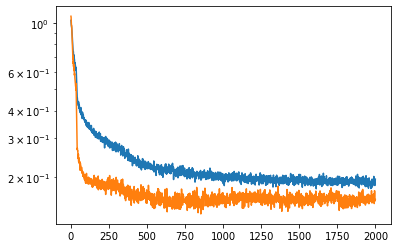

In [109]:
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])

In [110]:
val_err

0.14723627269268036

In [111]:
512*16

8192

In [112]:
128*128

16384